# CTR Prediction

#### This project was completed in July 2019 while I was a student at WeCloudData and edited in August 2020 for my portfolio. The purpose was to clean and explore data from an online ad agency, then build and test machine learning models that predict whether a user will click on an ad or not. My machine learning skills have progressed substantially since first completing this project, so I have added in a streamlined grid search and modelling section so that most of the machine learning and relevant outputs come from just 2 cells. The initial project is included afterwards as further illustration of my abilities. 

In [1]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score

In [2]:
df = pd.read_csv('CTR_prediction.csv')
df

## Exploratory Data Analysis

In [4]:
# drop secondary index column
df = df.drop(columns = 'Unnamed: 0')

In [5]:
# ~218K unique ID's
df.groupby('ID').size().sort_values(ascending = False)

ID
AMsySZaSHnOuwfEjIHSMTU237tQS    2231
AMsySZYzetqojeg0GiqNxk1-E49j    2214
AMsySZYo44CqBz2TZpaBq_4ycVeA    1876
AMsySZap-f-WDKrbqevE25h4Ywf7    1479
AMsySZbDZnAE8-ok03JhD3tWzfOM    1007
                                ... 
AMsySZaqBiT-fRMPJSs8xtdcyJXn       1
AMsySZZOWTrQXIMXzON6mSZOzlXD       1
AMsySZaqBUo6uf7_4UvfexCyA1Vf       1
AMsySZaqBKDnY8oU8hzspaO9O7uz       1
AMsySZY--16reUbF2secce11ks6g       1
Length: 218686, dtype: int64

In [6]:
# The target is very imbalanced in this data set - must be dealt with
# A model that ONLY predicts no click would be 99.99% accurate
# Hard for model to learn from so few click instances

df['Action'].value_counts().plot(kind='bar')

View     999756
Click       244
Name: Action, dtype: int64

In [7]:
# 244 clicks across 211 users - a fair amount of multi-click users
df[df['Action']=='Click'].groupby('ID').Action.value_counts().sort_values(ascending = False)

ID                            Action
AMsySZZFgj4VZQMNFAVg7RhrtwK9  Click     5
AMsySZaXOUFw6abC5kKlstcXiWgR  Click     4
AMsySZahqJUP-lAM8o0uuEn1wCQo  Click     3
AMsySZZx1kWE-I4zTCBuxc9O4aMB  Click     3
AMsySZZd-ZCF7AIfpXFQDcfP_iCS  Click     2
                                       ..
AMsySZaikx-LdJ56YhE_sjrB5j_5  Click     1
AMsySZahL50F0BM0WnET9X7yTsHm  Click     1
AMsySZafzCvCEi9du4sk57lF0cMB  Click     1
AMsySZafJm7Ontom1Ofdrp5eZS91  Click     1
AMsySZY1NUGdy0e_0WX1yUbtMzhi  Click     1
Name: Action, Length: 211, dtype: int64

In [8]:
# Exploring profile of clickers
df[df['Action']=='Click']

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
812,AMsySZb8b-J-eW7JOEuTeIUQ5qMg,1514261353516880,Click,Kijiji,160x600,JoeFresh,other,NaN
1117,AMsySZa1aKtjs-l2SIH7D7blDpA5,1507334361698311,Click,Amazon,160x600,Old Navy,Yellow,0.024737
4639,AMsySZZBGEKWlMNMsnbQ13mbopov,1513439807056947,Click,Facebook,300x250,Disney,Pink,0.474729
15419,AMsySZYtpCq1jCDG6_MR6U9RDbfC,1514698137893072,Click,Facebook,160x600,Carter's,Yellow,2.190019
24752,AMsySZamYm9kMjJQrErPrBESOpMv,1515529793236156,Click,Facebook,300x250,JoeFresh,Pink,0.789268
...,...,...,...,...,...,...,...,...
953617,AMsySZZyjNcp6RMnWzJPhHS-IX-9,1510620039104417,Click,Facebook,300x250,JoeFresh,Pink,0.371777
972051,AMsySZYsRd2zA4CNeeenIgyq8bze,1516898088722387,Click,Facebook,300x600,Gap,White,1.944049
975045,AMsySZYtrdpmhiIWMuGDkYVCWpCj,1513569481339033,Click,Facebook,1x1,Zara,Blue,0.266687
976073,AMsySZZx1kWE-I4zTCBuxc9O4aMB,1516676072360319,Click,Facebook,300x250,Carter's,Blue,0.324886


In [9]:
#Sync multiple 'Other' values
df.loc[df['BannerSize']=='other','BannerSize'] = 'Other'

In [10]:
#Convert BannerSize into an integer as BannerArea
#Other and 1x1 banners will be treated as NaNs since they are uninterpretable
df['BannerArea'] = df.loc[(df['BannerSize']!='Other')&(df['BannerSize']!='1x1'),'BannerSize'].str.split('x').str[0].astype(int) * \
df.loc[(df['BannerSize']!='Other')&(df['BannerSize']!='1x1'),'BannerSize'].str.split('x').str[1].astype(int)
df['BannerArea'].plot(kind='box');

0         180000.0
1          75000.0
2          65520.0
3          16000.0
4          75000.0
            ...   
999995     75000.0
999996    153600.0
999997     75000.0
999998     75000.0
999999         NaN
Name: BannerArea, Length: 1000000, dtype: float64

In [11]:
df['BannerArea'].value_counts().plot(kind='bar');

75000.0      408705
65520.0      196219
16000.0       62163
180000.0      59280
96000.0       57558
752400.0      32906
153600.0       7114
15000.0        1822
32000.0        1272
786432.0       1167
93750.0         572
3145728.0       319
Name: BannerArea, dtype: int64

In [12]:
df['Brand'].value_counts().plot(kind='bar');

Carter's                222635
JoeFresh                191722
Old Navy                150583
Banana Republic          84111
Burberry                 83346
Disney                   83205
gymboree                 70134
Zara                     55579
Gap                      30696
The Children's Place     27989
Name: Brand, dtype: int64

In [13]:
df['Website'].value_counts().plot(kind='bar');

Facebook         600137
Other             97616
Atedra            61637
instagram.com     56068
Craigslist.ca     39674
Yahoo             33731
TubeMogul         28551
Twitter           21086
Amazon            20601
Sympatico         11353
Kijiji             7726
Expedia            6992
Youtube            5150
Weather            5116
Wayfair            4002
AOL                 560
Name: Website, dtype: int64

In [14]:
df['colour'].value_counts().plot(kind='bar');

Pink      322837
Yellow    184132
Gold      161327
Blue      137856
Red        92381
White      55469
other      45998
Name: colour, dtype: int64

In [15]:
df.describe()

,ActionTime,InteractionTime,BannerArea
count,1.000000e+06,999992.000000,8.290970e+05
mean,1.508367e+15,0.998667,1.068558e+05
std,4.362784e+12,0.998170,1.506749e+05
min,1.500991e+15,0.000002,1.500000e+04
25%,1.505164e+15,0.288696,6.552000e+04
50%,1.507718e+15,0.693044,7.500000e+04
75%,1.511500e+15,1.382822,7.500000e+04
max,1.517358e+15,13.385281,3.145728e+06


In [16]:
df.isnull().sum()

ID                      0
ActionTime              0
Action                  0
Website                 0
BannerSize              0
Brand                   0
colour                  0
InteractionTime         8
BannerArea         170903
dtype: int64

In [17]:
# Can NOT drop null Interaction time because it contains 5 clicks
# Data is too imbalanced to drop these records
df[df.InteractionTime.isnull()]

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea
28,AMsySZbU2U0u2CDEQPae5UEvj7uh,1513974448167954,View,Facebook,728x90,Gap,Gold,NaN,65520.0
154,AMsySZZNSd4doewEvAFWe9U7SEub,1503968584487308,View,Facebook,320x50,Banana Republic,Gold,NaN,16000.0
812,AMsySZb8b-J-eW7JOEuTeIUQ5qMg,1514261353516880,Click,Kijiji,160x600,JoeFresh,other,NaN,96000.0
98269,AMsySZbCULOmzvMOl_jxgAPZnhmV,1512573518334683,Click,Facebook,300x250,Disney,Blue,NaN,75000.0
243356,AMsySZYtpCq1jCDG6_MR6U9RDbfC,1514698137892676,Click,Facebook,160x600,JoeFresh,Pink,NaN,96000.0
243357,AMsySZa6M_Z79mOnUWF9P8nKac5-,1516738555981098,View,Facebook,300x250,Carter's,Yellow,NaN,75000.0
331970,AMsySZbyqkZuERDU8VBWoJX_F4tD,1515278217655536,Click,Other,1x1,Old Navy,Pink,NaN,NaN
451827,AMsySZYZjTd1kTYooOpACb0cTDL2,1515692970262672,Click,Facebook,728x90,Old Navy,Pink,NaN,65520.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
ID                 1000000 non-null object
ActionTime         1000000 non-null int64
Action             1000000 non-null object
Website            1000000 non-null object
BannerSize         1000000 non-null object
Brand              1000000 non-null object
colour             1000000 non-null object
InteractionTime    999992 non-null float64
BannerArea         829097 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 68.7+ MB


## Feature Engineering

In [19]:
#Convert to DateTime and drop redundant 'ActionTime'
df['DateTime'] = pd.to_datetime(df['ActionTime'], unit='us')
df = df.drop(columns = 'ActionTime')
df['DateTime']

0        2017-10-23 12:30:59.495365
1        2017-08-16 01:37:49.736117
2        2017-12-25 02:37:11.528120
3        2018-01-09 19:59:12.591896
4        2017-10-09 02:06:49.374045
                    ...            
999995   2017-10-15 22:55:30.372165
999996   2018-01-24 02:17:21.253562
999997   2017-08-16 00:05:51.670170
999998   2018-01-27 15:55:11.614322
999999   2017-09-19 21:09:23.538153
Name: DateTime, Length: 1000000, dtype: datetime64[ns]

In [ ]:
plt.plot(df['DateTime'], df[df['Action']=='Click']);

In [20]:
# Explore profile of biggest clicker
df[df['ID']=='AMsySZZFgj4VZQMNFAVg7RhrtwK9'].sort_values('DateTime')

,ID,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea,DateTime
489317,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,300x250,The Children's Place,Red,2.733071,75000.0,2017-12-05 16:39:57.963630
307132,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,728x90,Burberry,Gold,0.139913,65520.0,2017-12-18 15:48:25.634898
397989,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,728x90,JoeFresh,Blue,0.482897,65520.0,2017-12-19 14:35:43.345732
402851,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,728x90,Carter's,Blue,0.175041,65520.0,2017-12-20 21:49:10.175080
301185,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,300x250,Carter's,Gold,0.560611,75000.0,2017-12-27 21:08:55.263678
862175,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,300x250,Old Navy,Yellow,0.213108,75000.0,2018-01-10 21:32:08.085104
712125,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,728x90,gymboree,Pink,1.914496,65520.0,2018-01-22 20:26:12.673974
67771,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,300x250,Burberry,Gold,0.183718,75000.0,2018-01-24 16:33:28.070674
976997,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,728x90,Old Navy,Gold,0.363942,65520.0,2018-01-26 17:23:08.445884
537669,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,300x600,JoeFresh,Red,0.380214,180000.0,2018-01-29 21:44:36.521835


In [21]:
# Extract Hour, DayWeek, Month, Year columns
df['Hour'] = df['DateTime'].dt.hour
df['DayWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year

In [22]:
#Create 'is it a Weekend' column
df['Weekend'] = df['DayWeek'].isin([5, 6]).astype(int)
df['Weekend']

0         0
1         0
2         0
3         0
4         0
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: Weekend, Length: 1000000, dtype: int32

In [23]:
#Bin hours into 4 seperate 6 hour blocks
df['TimeBin'] = pd.cut(df['Hour'],[0,6,12,18,24], include_lowest = True)
df['TimeBin']

0           (6.0, 12.0]
1         (-0.001, 6.0]
2         (-0.001, 6.0]
3          (18.0, 24.0]
4         (-0.001, 6.0]
              ...      
999995     (18.0, 24.0]
999996    (-0.001, 6.0]
999997    (-0.001, 6.0]
999998     (12.0, 18.0]
999999     (18.0, 24.0]
Name: TimeBin, Length: 1000000, dtype: category
Categories (4, interval[float64]): [(-0.001, 6.0] < (6.0, 12.0] < (12.0, 18.0] < (18.0, 24.0]]

In [24]:
# Convert Action=='Click' into binary Clicked column
df['Clicked'] = (df['Action']=='Click').astype(int)
df['Clicked'].value_counts()

0    999756
1       244
Name: Clicked, dtype: int64

In [25]:
#Converted Action=='View' into binary Viewed column
df['Viewed'] = (df['Action']=='View').astype(int)
df['Viewed'].value_counts()

1    999756
0       244
Name: Viewed, dtype: int64

In [26]:
#Cumulative clicks per user at the time of an impression
#If done carefully to avoid data leakage, we can use past clicks/views at time of interaction as feature

df['ClickCount'] = df.sort_values('DateTime').groupby('ID')['Clicked'].transform('cumsum')
df['ClickCount']

0         0
1         0
2         0
3         0
4         0
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Name: ClickCount, Length: 1000000, dtype: int32

In [27]:
#Confirming cumsum worked as intended
df[df['Action']=='Click'].sort_values('DateTime').head(100)

,ID,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea,DateTime,Hour,DayWeek,Month,Year,Weekend,TimeBin,Clicked,Viewed,ClickCount
55597,AMsySZaFZKflnrTSbjIOV7VnwmOr,Click,Yahoo,1200x627,Old Navy,Pink,0.488769,752400.0,2017-07-26 16:06:33.724023,16,2,7,2017,0,"(12.0, 18.0]",1,0,1
353193,AMsySZZMEpE-coa41TpTUHiuGUTM,Click,Facebook,300x250,Carter's,Pink,2.354688,75000.0,2017-07-27 18:26:37.474599,18,3,7,2017,0,"(12.0, 18.0]",1,0,1
29996,AMsySZYB1PocEUlgcuefzTdqHv3J,Click,Facebook,300x250,Disney,Red,3.460984,75000.0,2017-07-28 15:07:42.378128,15,4,7,2017,0,"(12.0, 18.0]",1,0,1
581558,AMsySZYtNKSHzYcHFhzH63-xOanX,Click,Facebook,728x90,Burberry,Red,0.367803,65520.0,2017-07-28 16:39:30.911979,16,4,7,2017,0,"(12.0, 18.0]",1,0,1
649353,AMsySZaU5VU-fJVQ2V8lqmqCAx8p,Click,Yahoo,1200x627,Burberry,Gold,0.847616,752400.0,2017-07-31 18:30:51.550972,18,0,7,2017,0,"(12.0, 18.0]",1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65621,AMsySZaQjrcGX1oNVo3J6WIB6bvp,Click,Kijiji,Other,Old Navy,Pink,0.795667,NaN,2017-11-06 17:11:47.646361,17,0,11,2017,0,"(12.0, 18.0]",1,0,1
35219,AMsySZZsUq8QBOnQjA10iNSPCrKn,Click,Kijiji,160x600,Carter's,Yellow,0.287192,96000.0,2017-11-08 17:39:09.639290,17,2,11,2017,0,"(12.0, 18.0]",1,0,1
472112,AMsySZY7rOQ37fAYhVWPeqiRKnLC,Click,instagram.com,300x250,Old Navy,Pink,0.588634,75000.0,2017-11-08 23:17:28.664788,23,2,11,2017,0,"(18.0, 24.0]",1,0,1
420518,AMsySZbGz2k6rqB6zwGkDqcC80pl,Click,Sympatico,300x250,JoeFresh,Yellow,0.240455,75000.0,2017-11-09 03:31:20.605442,3,3,11,2017,0,"(-0.001, 6.0]",1,0,1


In [30]:
#Must -1 so as to not count the current impression and leak data
df['ClickCount'] = df['ClickCount']-1

#Must reset -1 ClickCount values to 0 since -1 is an impossible value
df.loc[df['ClickCount']==-1,'ClickCount']=0

In [33]:
df['ClickCount'].value_counts().plot(kind='bar')

0    999913
1        63
3        15
2         6
4         3
Name: ClickCount, dtype: int64

In [28]:
#Cumulative views per user at the time of an impression
df['ViewCount'] = df.sort_values('DateTime').groupby('ID')['Viewed'].transform('cumsum')
df['ViewCount']

0          33
1           7
2           3
3           1
4          11
         ... 
999995    120
999996      1
999997      1
999998      4
999999     25
Name: ViewCount, Length: 1000000, dtype: int32

In [29]:
#Must -1 so as to not count the current impression and leak data
df['ViewCount'] = df['ViewCount']-1

#Must reset -1 ClickCount values to 0 since -1 is an impossible value
df.loc[df['ViewCount']==-1,'ViewCount']=0

In [34]:
df['ViewCount'].value_counts()

0       218742
1       117410
2        77809
3        57121
4        44646
         ...  
2218         1
2219         1
2216         1
2217         1
2214         1
Name: ViewCount, Length: 2231, dtype: int64

In [35]:
#Cumulative InteractionTime per user at the time of an impression
df['TimeCount'] = df.sort_values('DateTime').groupby('ID')['InteractionTime'].transform('cumsum')
df['TimeCount']

0          28.844307
1          13.156188
2           1.935283
3           0.802647
4          10.752797
             ...    
999995    100.714389
999996      0.059118
999997      0.025754
999998      1.101684
999999     23.532502
Name: TimeCount, Length: 1000000, dtype: float64

In [36]:
#See all columns
with pd.option_context('display.max_columns', None):
    display(df)

,ID,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea,DateTime,Hour,DayWeek,Month,Year,Weekend,TimeBin,Clicked,Viewed,ClickCount,ViewCount,TimeCount
0,AMsySZbNg8SBwPtj7IGHnip_8aY0,View,Facebook,300x600,Carter's,Pink,0.171601,180000.0,2017-10-23 12:30:59.495365,12,0,10,2017,0,"(6.0, 12.0]",0,1,0,32,28.844307
1,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,View,Facebook,300x250,Burberry,Red,4.303945,75000.0,2017-08-16 01:37:49.736117,1,2,8,2017,0,"(-0.001, 6.0]",0,1,0,6,13.156188
2,AMsySZYoK8_bD0hGv4zu0iRn1TFo,View,Facebook,728x90,Disney,Yellow,0.868106,65520.0,2017-12-25 02:37:11.528120,2,0,12,2017,0,"(-0.001, 6.0]",0,1,0,2,1.935283
3,AMsySZahxpwLOWnMJj6RGATgwEOc,View,Facebook,320x50,Carter's,Yellow,0.802647,16000.0,2018-01-09 19:59:12.591896,19,1,1,2018,0,"(18.0, 24.0]",0,1,0,0,0.802647
4,AMsySZbqgfMBDtAqZz1jVRaOmX00,View,instagram.com,300x250,Gap,Gold,0.627148,75000.0,2017-10-09 02:06:49.374045,2,0,10,2017,0,"(-0.001, 6.0]",0,1,0,10,10.752797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,AMsySZY-9Mzh_xjk57_PBNO_8QRO,View,instagram.com,300x250,Old Navy,Yellow,0.049011,75000.0,2017-10-15 22:55:30.372165,22,6,10,2017,1,"(18.0, 24.0]",0,1,0,119,100.714389
999996,AMsySZY-KoDAx1qJv15SZ9lKO2QF,View,Twitter,320x480,JoeFresh,Yellow,0.059118,153600.0,2018-01-24 02:17:21.253562,2,2,1,2018,0,"(-0.001, 6.0]",0,1,0,0,0.059118
999997,AMsySZZGRYHeXVjPP2Rr6F-kjFc3,View,Other,300x250,JoeFresh,Pink,0.025754,75000.0,2017-08-16 00:05:51.670170,0,2,8,2017,0,"(-0.001, 6.0]",0,1,0,0,0.025754
999998,AMsySZaSAhXiCSGhaCLWcoLse-0i,View,Facebook,300x250,Old Navy,Pink,0.453710,75000.0,2018-01-27 15:55:11.614322,15,5,1,2018,1,"(12.0, 18.0]",0,1,0,3,1.101684


## Modelling

In [38]:
#Year was dropped since the data only spans 18 months
#All other dropped columns were redundant or leak data
#Our target is whether an impression was clicked or not (1 for clicked, 0 for viewed)

X = df.drop(columns = ['DateTime', 'BannerSize', 'Action', 'ID', 'Clicked', \
                       'Viewed', 'Year'])
y = df['Clicked']

In [39]:
#Use One Hot encoding to obtain dummies for categorical variables
#Drop first was used to avoid having a redundant dummy column
X = pd.get_dummies(X, drop_first = True)
X

,InteractionTime,BannerArea,Hour,DayWeek,Month,Weekend,ClickCount,ViewCount,TimeCount,Website_Amazon,...,Brand_gymboree,colour_Gold,colour_Pink,colour_Red,colour_White,colour_Yellow,colour_other,"TimeBin_(6.0, 12.0]","TimeBin_(12.0, 18.0]","TimeBin_(18.0, 24.0]"
0,0.171601,180000.0,12,0,10,0,0,32,28.844307,0,...,0,0,1,0,0,0,0,1,0,0
1,4.303945,75000.0,1,2,8,0,0,6,13.156188,0,...,0,0,0,1,0,0,0,0,0,0
2,0.868106,65520.0,2,0,12,0,0,2,1.935283,0,...,0,0,0,0,0,1,0,0,0,0
3,0.802647,16000.0,19,1,1,0,0,0,0.802647,0,...,0,0,0,0,0,1,0,0,0,1
4,0.627148,75000.0,2,0,10,0,0,10,10.752797,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.049011,75000.0,22,6,10,1,0,119,100.714389,0,...,0,0,0,0,0,1,0,0,0,1
999996,0.059118,153600.0,2,2,1,0,0,0,0.059118,0,...,0,0,0,0,0,1,0,0,0,0
999997,0.025754,75000.0,0,2,8,0,0,0,0.025754,0,...,0,0,1,0,0,0,0,0,0,0
999998,0.453710,75000.0,15,5,1,1,0,3,1.101684,0,...,0,0,1,0,0,0,0,0,1,0


In [40]:
#Train, test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [41]:
#inplace = True??

#Imputed InteractionTime, TimeCount, and BannerArea missing values w/ the mean of their columns
#These imputations were performed after the train, test split to avoid data leakage

X_train.loc[:,'InteractionTime'] = X_train.loc[:,'InteractionTime'].fillna(X_train['InteractionTime'].mean())
X_test.loc[:,'InteractionTime'] = X_test.loc[:,'InteractionTime'].fillna(X_test['InteractionTime'].mean())

X_train.loc[:,'TimeCount'] = X_train.loc[:,'TimeCount'].fillna(X_train['TimeCount'].mean())
X_test.loc[:,'TimeCount'] = X_test.loc[:,'TimeCount'].fillna(X_test['TimeCount'].mean())

X_train.loc[:,'BannerArea'] = X_train.loc[:,'BannerArea'].fillna(X_train['BannerArea'].mean())
X_test.loc[:,'BannerArea'] = X_test.loc[:,'BannerArea'].fillna(X_test['BannerArea'].mean())

C:\Users\todds\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [103]:
scaler = StandardScaler()

samplers = [SMOTE(random_state=42), RandomOverSampler(random_state=42)]

model_list = [DecisionTreeClassifier(random_state=42), 
              LogisticRegression(random_state=42)]
              #RandomForestClassifier(random_state=42)]
              #xgb.XGBRegressor(objective ='reg:linear', random_state = 42)]

## Grid Search

In [199]:
parameters = {}

parameters['DT'] = {
    'sm__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
    'mod__max_depth':[5,10,25,50],
    'mod__max_features':[5,10,15,25,40],
    'mod__criterion':['gini','entropy']
}

parameters['LR'] = {
    'sm__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
    'mod__C':[0.01,0.1,1,10,100],
    'mod__penalty':['none','l1','l2'],
    'mod__max_iter':[25,50,100,200],
    'mod__solver':['lbfgs','liblinear']
}

#parameters['RF'] = {
 #   'sm__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
  #  'mod__max_depth':[5,10,15,20,50],
   # 'mod__n_estimators': [5,10,15,25,50],
    #'mod__max_features':['auto','sqrt'],
    #'mod__criterion':['gini','entropy']
#}

#parameters['XGB'] = {
  #  'max_depth':[3,5,10,15,25],
   # 'n_estimators': [5,10,15,25,50,100],
   # 'colsample_bytree': [0.1,0.3,0.5,0.7,0.9],
   # 'learning_rate': [0.01,0.1,0.2,0.5,1],
   # 'alpha':[0.001,0.1,1,10]
    #booster
#}

In [ ]:
%%time
#Grid search loop for all models AND samplers
#The many warnings we get are acceptable. We are testing many models here and some of them are suboptimal
#While unsightly in the notebook, these outputs would be cleaned up in a PowerPoint when presented to stakeholders

#cv = 5?
#kf = StratifiedKFold(n_splits = 5)
#scoring = 'f1'
END_models = {}
final_models = {}
best_params = pd.DataFrame()

for samp, sampler in zip(['SMOTE','ROS'], samplers):
    END_models[samp] = []
    for model, long_model in zip(parameters.keys(), model_list):
            pipeline = Pipeline([('scale', scaler), ('sm', sampler), ('mod', long_model)])

            grid = GridSearchCV(pipeline, param_grid=parameters[model], cv = 3,
                                scoring = 'f1', n_jobs = -1)
            grid.fit(X_train, y_train)

            best_params.loc[model,'Best_Params'] = str(grid.best_params_)
            final_models[model] = grid.best_estimator_
            END_models[samp].append(final_models[model])

            try:
                print(model +' '+ samp +': '+str(grid.best_params_))
            except:
                pass

DT SMOTE: {'mod__criterion': 'entropy', 'mod__max_depth': 5, 'mod__max_features': 15, 'sm__sampling_strategy': 0.01}


In [105]:
%%time
#Grid search loop for all models AND samplers
#The many warnings we get are acceptable. We are testing many models here and some of them are suboptimal
#While unsightly in the notebook, these outputs would be cleaned up in a PowerPoint when presented to stakeholders

#kf = StratifiedKFold(n_splits = 5)
#scoring = 'f1'
END_models = {}
final_models = {}
best_params = pd.DataFrame()

for samp, sampler in zip(['SMOTE','ROS'], samplers):
    END_models[samp] = []
    for model, long_model in zip(parameters.keys(), model_list):
            pipeline = Pipeline([('scale', scaler), ('sm', sampler), ('mod', long_model)])

            grid = GridSearchCV(pipeline, param_grid=parameters[model], cv = 3,
                                scoring = 'f1', n_jobs = -1)
            grid.fit(X_train, y_train)

            best_params.loc[model,'Best_Params'] = str(grid.best_params_)
            final_models[model] = grid.best_estimator_
            END_models[samp].append(final_models[model])

            try:
                print(model +' '+ samp +': '+str(grid.best_params_))
            except:
                pass

DT SMOTE: {'mod__criterion': 'gini', 'mod__max_depth': 5, 'mod__max_features': 10, 'sm__sampling_strategy': 0.01}


C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR SMOTE: {'mod__C': 0.01, 'mod__max_iter': 50, 'mod__penalty': 'none', 'sm__sampling_strategy': 0.01}
DT ROS: {'mod__criterion': 'gini', 'mod__max_depth': 5, 'mod__max_features': 10, 'sm__sampling_strategy': 0.01}


C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


LR ROS: {'mod__C': 0.01, 'mod__max_iter': 50, 'mod__penalty': 'none', 'sm__sampling_strategy': 0.01}
Wall time: 53min 1s


C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [120]:
END_models['ROS'][1]['mod']
#[1]['mod']

LogisticRegression(C=0.01, max_iter=50, penalty='none', random_state=42)

In [111]:
final_models

{'DT': Pipeline(steps=[('scale', StandardScaler()),
                 ('sm',
                  RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                 ('mod',
                  DecisionTreeClassifier(max_depth=5, max_features=10,
                                         random_state=42))]),
 'LR': Pipeline(steps=[('scale', StandardScaler()),
                 ('sm',
                  RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                 ('mod',
                  LogisticRegression(C=0.01, max_iter=50, penalty='none',
                                     random_state=42))])}

In [126]:
import warnings
#warnings.simplefilter(action='ignore', category='ConvergenceWarning')

NameError: name 'ConvergenceWarning' is not defined

## Best Models

In [ ]:
#Return all model outputs at once, with tuned hyperparameters
%%time
for samp in ['SMOTE','ROS']:
    for pipeline in END_models[samp]:
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'f1')

        print(f'Model: {pipeline}')
        print("\n")
        print(f'Training F1 Score: {scores.mean()}')
        print(f'Test F1 Score: {f1_score(y_pred, y_test)}')
        print("\n")
        print(classification_report(y_test, y_pred))
        skplt.metrics.plot_confusion_matrix(y_test, y_pred)
        plt.show();
        try:
            skplt.estimators.plot_feature_importances(pipeline['mod'], feature_names=X.columns, \
                                                      figsize=(15, 10), x_tick_rotation=90)
            plt.show();
        except:
            pd.Series(pipeline['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar')

## Decision Tree

### DT Grid Search

In [157]:
#performing 2 seperate grid searches, using SMOTE and ROS
#Different oversamplers will create different data, meaning different hyperparameters will optimize each model
%%time

DT = DecisionTreeClassifier(random_state=42)
kf = StratifiedKFold(n_splits = 5)
DTgrid = {}

for samp, sampler in zip(['SMOTE','ROS'], samplers):
    DTpipeline = Pipeline([('samp', sampler), ('mod', DT)])

    DTparams = {'samp__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
              'mod__max_depth': [5,10,15,25,50],
              'mod__max_features':[5,10,15,25,40],
              'mod__criterion': ['gini','entropy']
    }

    DTgrid[samp] = RandomizedSearchCV(DTpipeline, param_distributions = DTparams, scoring = 'f1', cv = kf, random_state=42)

    DTgrid[samp].fit(X_train, y_train)

In [158]:
#RANDOM STATE EVERYTHING?

In [159]:
DTmodel = {}
DTmodel['Original'] = DTgrid['ROS'].best_estimator_['mod']
DTmodel['Original']

DecisionTreeClassifier(max_depth=5, max_features=10, random_state=42)

### DT w/ original data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.67      0.06      0.10        71

    accuracy                           1.00    250000
   macro avg       0.83      0.53      0.55    250000
weighted avg       1.00      1.00      1.00    250000



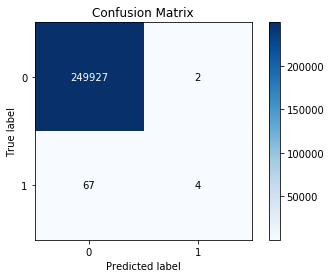

Cross Val F1 Score: 0.158049669628617
Test F1 Score: 0.1038961038961039


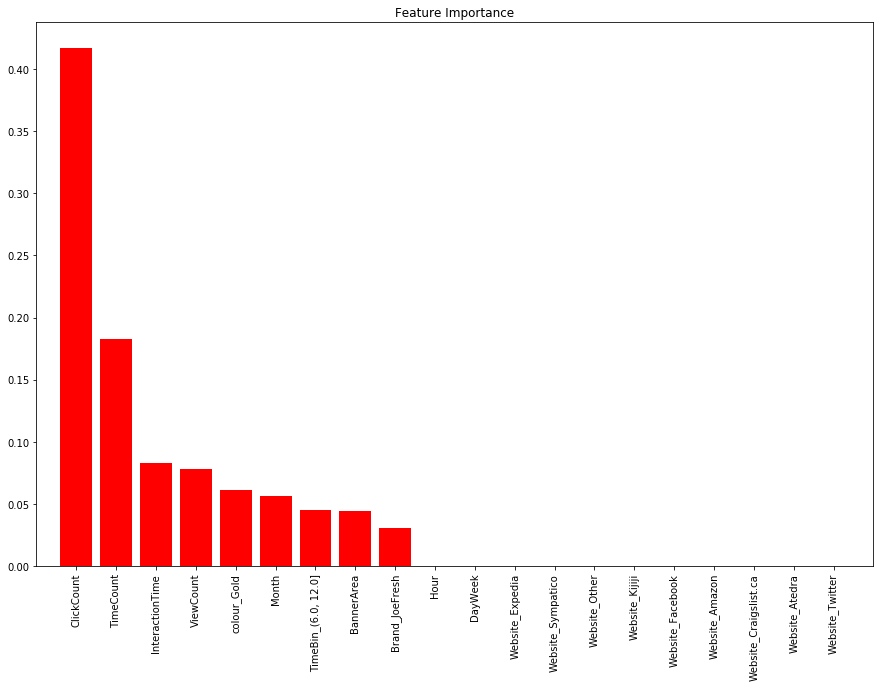

In [160]:
DTmodel['Original'].fit(X_train, y_train)

y_pred = DTmodel['Original'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(DTmodel['Original'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Cross Val F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(DTmodel['Original'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### DT w/ Random Over Sampler

In [161]:
DTmodel['ROS'] = DTgrid['ROS'].best_estimator_
#DTmodel = DTgrid['ROS'].best_estimator_['mod']
#ros = DTgrid['ROS'].best_estimator_['samp']
#X_ros, y_ros = ros.fit_resample(X_train, y_train)
DTmodel['ROS']

Pipeline(steps=[('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 DecisionTreeClassifier(max_depth=5, max_features=10,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.45      0.14      0.22        71

    accuracy                           1.00    250000
   macro avg       0.73      0.57      0.61    250000
weighted avg       1.00      1.00      1.00    250000



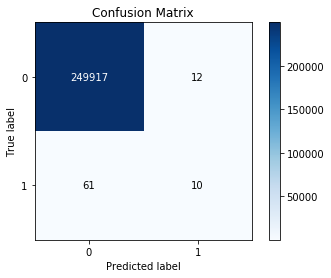

Cross Val Score: 0.2049206349206349
Test F1 Score: 0.21505376344086022


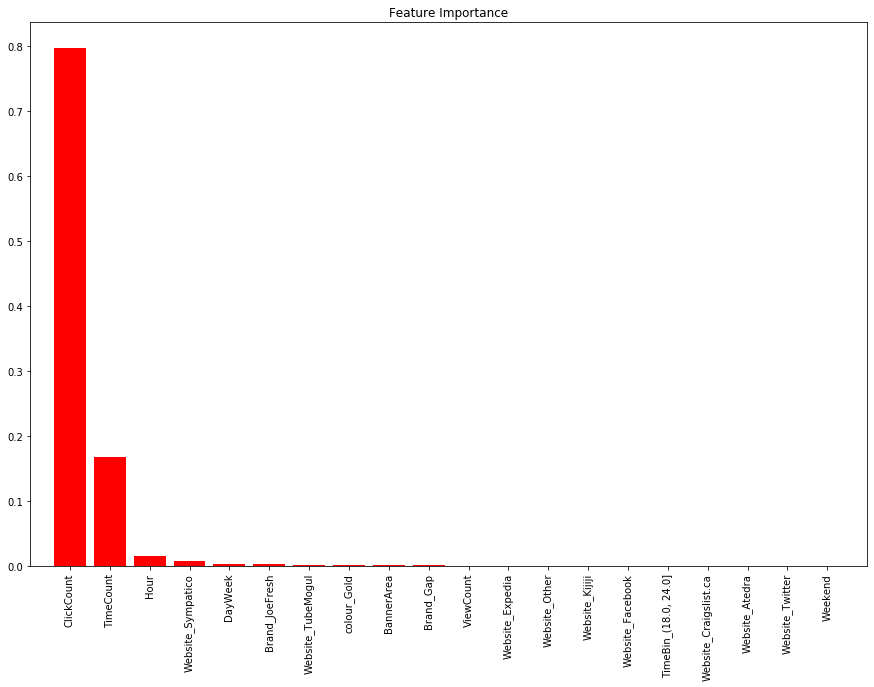

In [162]:
DTmodel['ROS'].fit(X_train, y_train)

y_pred = DTmodel['ROS'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(DTmodel['ROS'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Cross Val Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(DTmodel['ROS']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### DT w/ SMOTE

In [163]:
DTmodel['SMOTE'] = DTgrid['SMOTE'].best_estimator_
#DTmodel = DTgrid['SMOTE'].best_estimator_['mod']
#smote = DTgrid['SMOTE'].best_estimator_['samp']
#X_smote, y_smote = smote.fit_resample(X_train, y_train)
#print(smote)
DTmodel['SMOTE']

Pipeline(steps=[('samp', SMOTE(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 DecisionTreeClassifier(max_depth=5, max_features=10,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.52      0.15      0.24        71

    accuracy                           1.00    250000
   macro avg       0.76      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



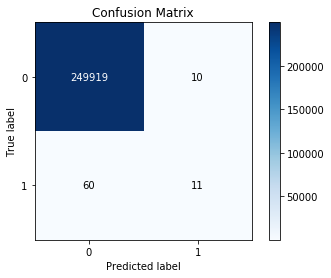

Cross Val Score: 0.1472042475526796
Test F1 Score: 0.23913043478260868


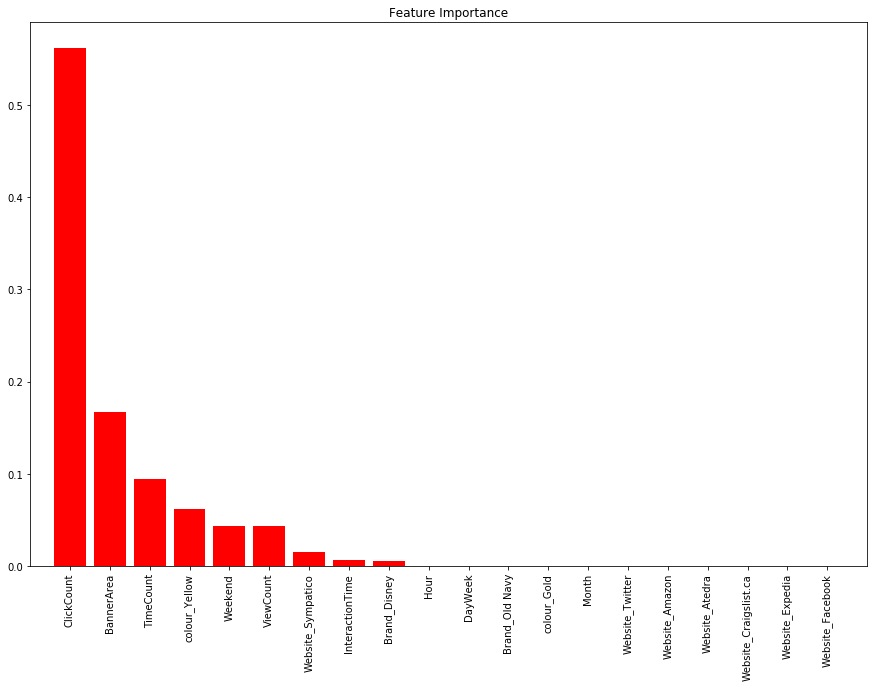

In [164]:
DTmodel['SMOTE'].fit(X_train, y_train)

y_pred = DTmodel['SMOTE'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(DTmodel['SMOTE'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Cross Val Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(DTmodel['SMOTE']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

#### ROS and SMOTE produce similair classification reports. Both have issues to keep in mind: ROS overfits the training data, which is typical of the method. The feature importances for SMOTE seem much more random and nonsensical than the other two DT models and there is a concern the SMOTE model is overfit to synthetic data. The ROS model helps us find an additional click case than the model w/out oversampling - is it worth manipulating the dataset for? Likely yes with such an imabalnced dataset where finding the target is such a difficult task, but this would be largely informed by business objectives.


## Random Forest

### RF Grid Search

In [175]:
%%time
RF = RandomForestClassifier(random_state=42)
kf = StratifiedKFold(n_splits = 5)
RFgrid = {}

for samp, sampler in zip(['SMOTE','ROS'], samplers):

    RFpipeline = Pipeline([('samp', sampler), ('mod', RF)])

    RFparams = {'samp__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
                'mod__max_depth': [5,10,15,25,50],
                'mod__n_estimators': [5,10,15,25,50],
                'mod__max_features': ['auto','sqrt'],
                'mod__criterion': ['gini','entropy']
    }

    RFgrid[samp] = RandomizedSearchCV(RFpipeline, param_distributions = RFparams, scoring = 'f1', cv = kf, random_state=15)

    RFgrid[samp].fit(X_train, y_train)

In [176]:
RFgrid['ROS'].best_estimator_

Pipeline(steps=[('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=5, random_state=42))])

In [177]:
RFgrid['SMOTE'].best_estimator_

Pipeline(steps=[('samp', SMOTE(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=5, random_state=42))])

In [178]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mod__C,param_mod__max_iter,param_mod__penalty,param_sm__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.768870,0.560414,0.696136,0.125805,0.01,5,none,0.001,"{'mod__C': 0.01, 'mod__max_iter': 5, 'mod__pen...",0.170732,0.256410,0.136986,0.188043,0.050268,20
1,5.785675,0.581776,0.757253,0.023996,0.01,5,none,0.01,"{'mod__C': 0.01, 'mod__max_iter': 5, 'mod__pen...",0.170732,0.256410,0.136986,0.188043,0.050268,20
2,5.388224,0.460530,0.511996,0.009140,0.01,5,none,0.1,"{'mod__C': 0.01, 'mod__max_iter': 5, 'mod__pen...",0.054217,0.013415,0.075188,0.047606,0.025648,102
3,5.697401,1.084158,0.613037,0.201689,0.01,5,none,0.25,"{'mod__C': 0.01, 'mod__max_iter': 5, 'mod__pen...",0.007389,0.051813,0.012282,0.023828,0.019889,123
4,7.146940,0.717360,0.662406,0.210930,0.01,5,none,0.5,"{'mod__C': 0.01, 'mod__max_iter': 5, 'mod__pen...",0.001450,0.001734,0.001459,0.001548,0.000132,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,13.711603,0.238760,0.570487,0.089105,100,50,l2,0.001,"{'mod__C': 100, 'mod__max_iter': 50, 'mod__pen...",0.184211,0.257143,0.115942,0.185765,0.057655,52
196,15.420833,0.008340,0.492360,0.023558,100,50,l2,0.01,"{'mod__C': 100, 'mod__max_iter': 50, 'mod__pen...",0.181818,0.263158,0.142857,0.195944,0.050118,1
197,17.273251,2.194468,0.559514,0.071045,100,50,l2,0.1,"{'mod__C': 100, 'mod__max_iter': 50, 'mod__pen...",0.043887,0.074627,0.100000,0.072838,0.022943,97
198,16.901473,1.090945,0.490356,0.053276,100,50,l2,0.25,"{'mod__C': 100, 'mod__max_iter': 50, 'mod__pen...",0.004482,0.009557,0.006459,0.006833,0.002089,158


In [179]:
RFmodel = {}
RFmodel['Original'] = RFgrid['ROS'].best_estimator_['mod']
RFmodel['Original']
#RandomForestClassifier(max_depth = 50, n_estimators = 5)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=5,
                       random_state=42)

### RF w/ Original Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.67      0.03      0.05        71

    accuracy                           1.00    250000
   macro avg       0.83      0.51      0.53    250000
weighted avg       1.00      1.00      1.00    250000



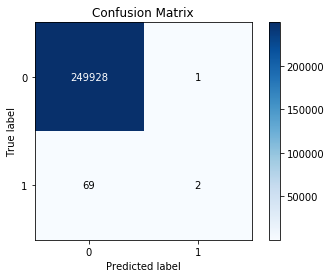

Cross Val F1 Score: 0.0616374269005848
Test F1 Score: 0.054054054054054064


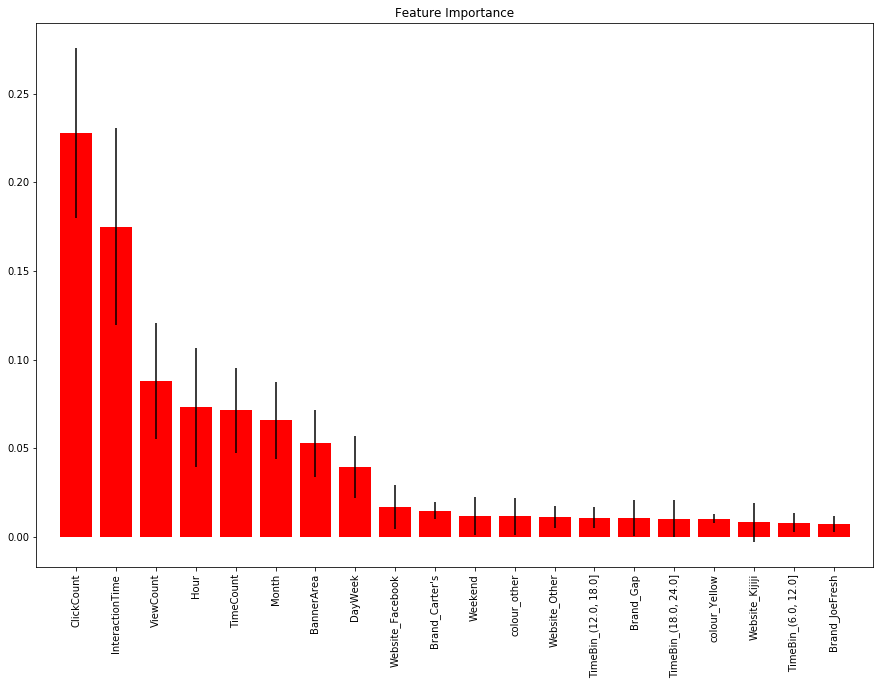

In [180]:
RFmodel['Original'].fit(X_train, y_train)

y_pred = RFmodel['Original'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(RFmodel['Original'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Cross Val F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(RFmodel['Original'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### RF w/ Random Over Sampler

In [181]:
RFmodel['ROS'] = RFgrid['ROS'].best_estimator_
RFmodel['ROS']
#ros = RFgrid['ROS'].best_estimator_['samp']
#RandomOverSampler(sampling_strategy = .001)
#X_ros, y_ros = ros.fit_resample(X_train, y_train)

Pipeline(steps=[('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=5, random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.57      0.06      0.10        71

    accuracy                           1.00    250000
   macro avg       0.79      0.53      0.55    250000
weighted avg       1.00      1.00      1.00    250000



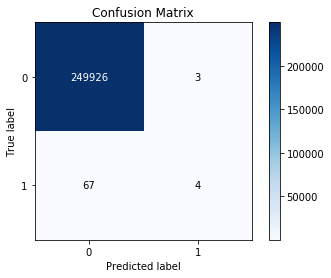

Training F1 Score: 0.11841557950463225
Test F1 Score: 0.10256410256410255


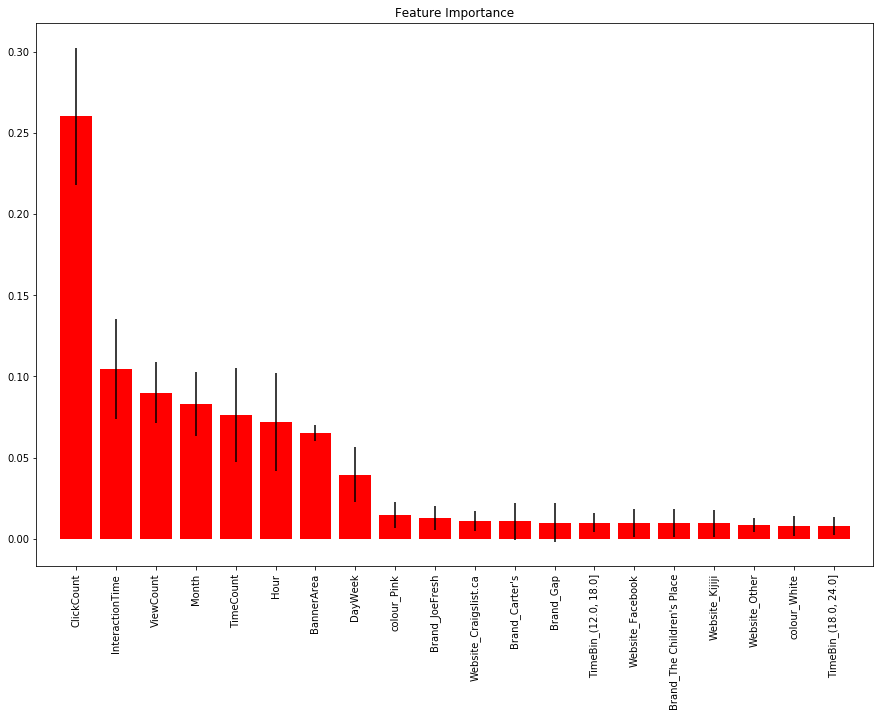

In [182]:
RFmodel['ROS'].fit(X_train, y_train)

y_pred = RFmodel['ROS'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(RFmodel['ROS'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(RFmodel['ROS']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### RF w/ SMOTE

In [183]:
RFmodel['SMOTE'] = RFgrid['SMOTE'].best_estimator_
RFmodel['SMOTE']
#smote = RFgrid['SMOTE'].best_estimator_['samp']
#SMOTE(sampling_strategy = 0.1)
#X_smote, y_smote = smote.fit_resample(X_train, y_train)

Pipeline(steps=[('samp', SMOTE(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=5, random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.45      0.07      0.12        71

    accuracy                           1.00    250000
   macro avg       0.73      0.54      0.56    250000
weighted avg       1.00      1.00      1.00    250000



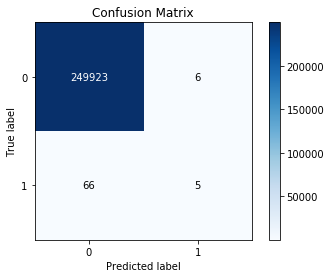

Training F1 Score: 0.12114050779901453
Test F1 Score: 0.12195121951219513


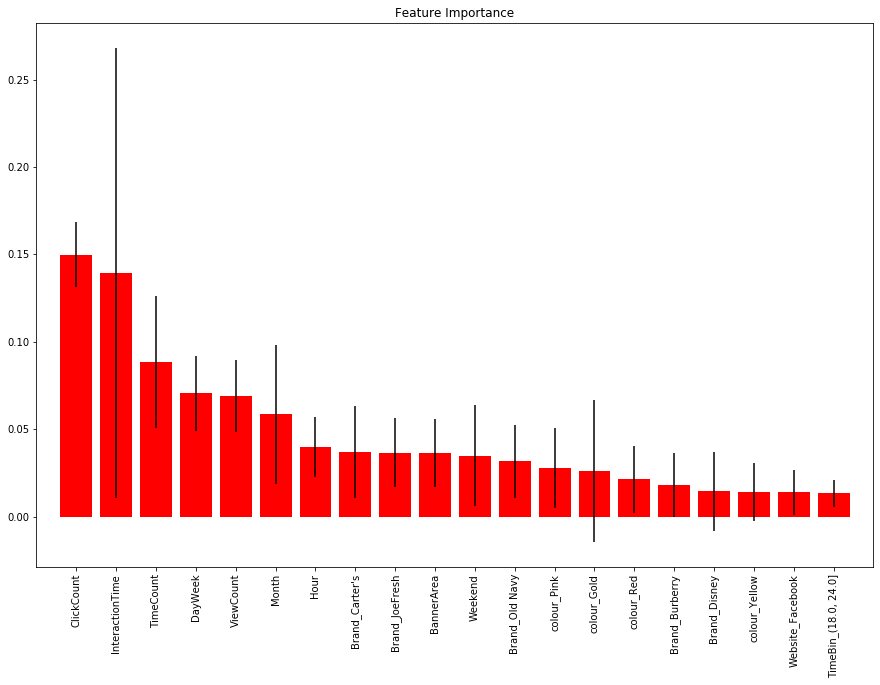

In [184]:
RFmodel['SMOTE'].fit(X_train, y_train)

y_pred = RFmodel['SMOTE'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(RFmodel['SMOTE'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(RFmodel['SMOTE']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

#### The strongest Random Forest model is the SMOTE model. It performs as well as the ROS model on the test set, but the ROS model is very overfit to the training set making it less robust and less likely to fit well to unseen test sets. We prefer SMOTE because it is more likely it has keyed in on the signal and not the noise; the feature importance graphs support this idea. 

## Logistic Regression (BEST MODEL!)

### LR Grid Search

In [185]:
#Data must be scaled for LR
#Tuned w/ f1
%%time

LR = LogisticRegression(random_state=42)
kf = StratifiedKFold(n_splits = 5)
LRgrid = {}

for samp, sampler in zip(['SMOTE','ROS'], samplers):

    pipeline = Pipeline([('scale', scaler), ('samp', sampler), ('mod', LR)])

    LRparams = {
                'samp__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
                'mod__C':[0.01,0.1,1,10,100],
                'mod__penalty':['none','l1','l2'],
                'mod__max_iter':[25,50,100,200],
                'mod__solver':['lbfgs','liblinear']
                }

    LRgrid[samp] = RandomizedSearchCV(pipeline, param_distributions = LRparams, scoring = 'f1', cv = kf, random_state=15)

    LRgrid[samp].fit(X_train, y_train)

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Use

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Use

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Use

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Use

In [186]:
LRgrid['SMOTE'].best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('samp', SMOTE(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 LogisticRegression(C=100, max_iter=25, random_state=42))])

### LR w/ Original Data

In [188]:
#We use the model hyperparameters from the 'SMOTE' grid search, but do not use an oversampler here
#Small gains would come from tuning the hyperparams on original data, but in testing the original data never produced best model
#Therefore omitted to save time

LRmodel = {}
LRmodel['Original'] = LRgrid['ROS'].best_estimator_['mod']
LRmodel['Original']

LogisticRegression(C=100, max_iter=25, random_state=42)

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.60      0.04      0.08        71

    accuracy                           1.00    250000
   macro avg       0.80      0.52      0.54    250000
weighted avg       1.00      1.00      1.00    250000



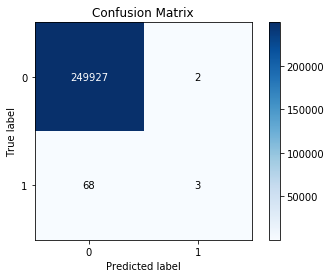

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Training F1 Score: 0.0327485380116959
Test F1 Score: 0.07894736842105261


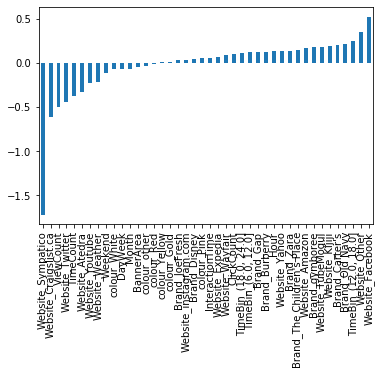

In [189]:
pipeline = Pipeline([('scale', scaler), ('mod', LRmodel['Original'])])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

pd.Series(pipeline['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar');

In [190]:
pipeline['mod'].predict_proba(X_test)[:,1].sum()

1.0052491378987315e-280

In [191]:
LR_proba = pipeline['mod'].predict_proba(X_test)[:, 1]

print(roc_auc_score(y_test, LR_proba))

0.5017716017264395


C:\Users\todds\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.00      0.00      0.00        71

    accuracy                           1.00    250000
   macro avg       0.50      0.50      0.50    250000
weighted avg       1.00      1.00      1.00    250000



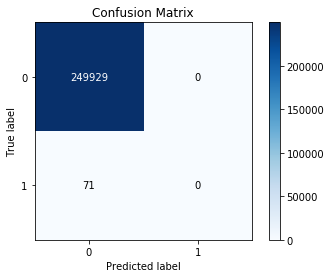

In [192]:
#!!!!!!!!!!
#BEST MODEL
#Reducing predicted probability to 0.01 works v well on the test set
#This makes intuitive sense since we can never have high confidence in such an imbalanced dataset

print(classification_report(y_test, (LR_proba  >= 0.1).astype(int)))
skplt.metrics.plot_confusion_matrix(y_test, (LR_proba  >= 0.01).astype(int));

### LR w/ Random Over Sampler

In [193]:
LRmodel['ROS'] = LRgrid['ROS'].best_estimator_
LRmodel['ROS']

Pipeline(steps=[('scale', StandardScaler()),
                ('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.1)),
                ('mod',
                 LogisticRegression(C=100, max_iter=25, random_state=42))])

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.23      0.15      0.18        71

    accuracy                           1.00    250000
   macro avg       0.61      0.58      0.59    250000
weighted avg       1.00      1.00      1.00    250000



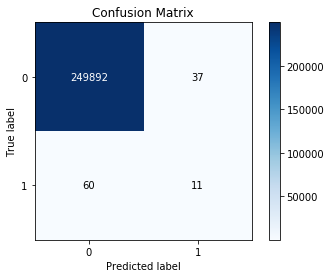

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Training F1 Score: 0.14286764256134646
Test F1 Score: 0.18487394957983194


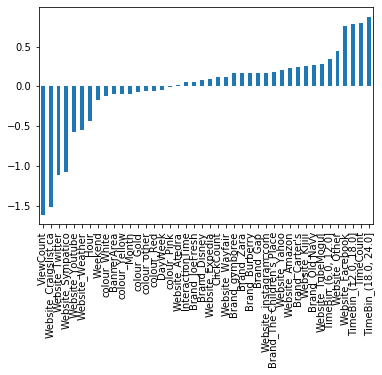

In [194]:
LRmodel['ROS'].fit(X_train, y_train)

y_pred = LRmodel['ROS'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(LRmodel['ROS'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

pd.Series(LRmodel['ROS']['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar');

In [195]:
print(roc_auc_score(y_test, y_pred))

0.5773907677104241


### LR w/ SMOTE

In [196]:
LRmodel['SMOTE'] = LRgrid['SMOTE'].best_estimator_
LRmodel['SMOTE']

Pipeline(steps=[('scale', StandardScaler()),
                ('samp', SMOTE(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 LogisticRegression(C=100, max_iter=25, random_state=42))])

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.47      0.10      0.16        71

    accuracy                           1.00    250000
   macro avg       0.73      0.55      0.58    250000
weighted avg       1.00      1.00      1.00    250000



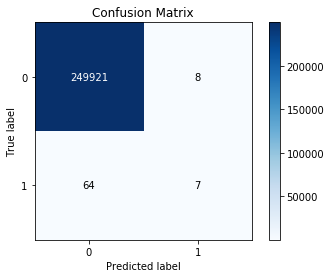

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Training F1 Score: 0.14109354624472206
Test F1 Score: 0.1627906976744186


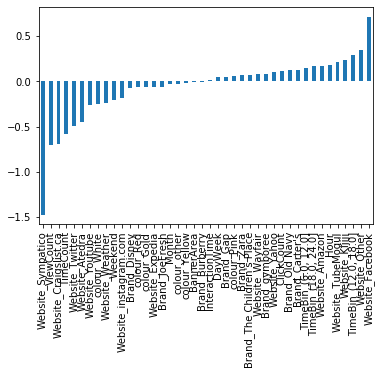

In [197]:
LRmodel['SMOTE'].fit(X_train, y_train)  

y_pred = LRmodel['SMOTE'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(LRmodel['SMOTE'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

pd.Series(LRmodel['SMOTE']['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar');

In [198]:
print(roc_auc_score(y_test, LR_proba))

0.5017716017264395


#### It is important to properly define the performance metric you are measuring and tuning your model with, especially with an imbalanced dataset. For example, a model that only predicted non-clicks would be 99.99% accurate, but completely uselss for the business objective.Tuning on recall will return the most true positives, however it will come at the cost of many false positives. Tuning on precision will .... F1 scores are derived from a formula including precision and recall and is generally a good balanced apporach for these situations. The model puts a premium on finding true positives, but not at the cost of classifying 40% of the data erroneously. 

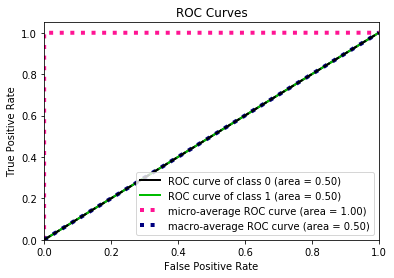

In [130]:
from scikitplot.metrics import plot_roc

plot_roc(y_test, LRmodel.predict_proba(X_test));

### PCA

In [540]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

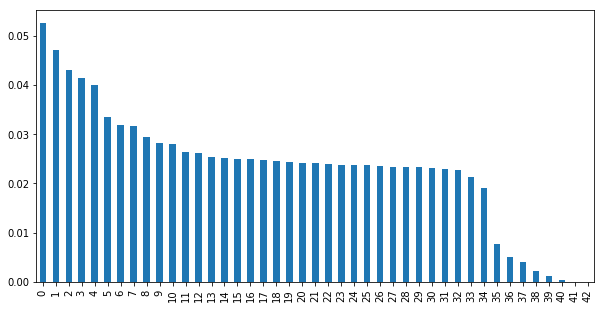

In [326]:
pd.Series(pca.explained_variance_ratio_).plot('bar', figsize = (10, 5));
#pca was fit to the data in fit_transfrom above

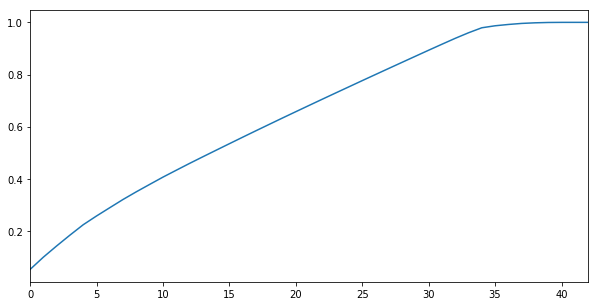

In [327]:
pd.Series(pca.explained_variance_ratio_.cumsum()).plot('line', figsize=(10,5));

In [557]:
#Define how many principle components you want
pca = PCA(30)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

X_train_pca.shape

(750000, 30)

In [549]:
X_train_scaled.shape

(750000, 42)

In [558]:
#Logisitc Regression w/ PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

LRmodel = LogisticRegression(max_iter = 12, penalty = 'l1', C = 10000)
LRmodel.fit(X_train_pca, y_train)
y_pred = LRmodel.predict(X_test_pca)
#LRmodel.score(X_test, y_test)
scores = cross_val_score(LRmodel, X_train_pca, y_train, cv=5)
print(scores.mean())
print(classification_report(y_test, y_pred))

#PCA 30 = 3, 1250, 68
#PCA 25 = 1, 4, 70
# PCA 15 = 0, 0

/Users/samanthamiller/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/samanthamiller/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/samanthamiller/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/samanthamiller/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/samanthamiller/an

0.9997586667022136
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.43      0.04      0.08        71

   micro avg       1.00      1.00      1.00    250000
   macro avg       0.71      0.52      0.54    250000
weighted avg       1.00      1.00      1.00    250000



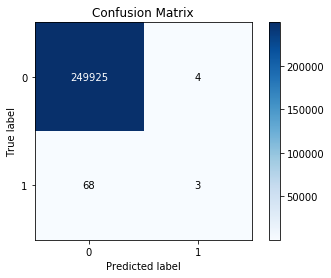

In [559]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred);

## Rough Work

In [ ]:
#SVC kept breaking my computer
#SVCmodel = SVC()

#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.fit_transform(X_test)

#SVCmodel.fit(X_train_scaled, y_train)

#y_pred = SVCmodel.predict(X_test_scaled)

#scores = cross_val_score(SVCmodel, X_train_scaled, y_train, cv=5, scoring = 'f1')
#scores.mean()

#class_weight, C, max_iter

In [ ]:
scaler = StandardScaler()
samplers = [SMOTE(), RandomOverSampler()]
models = [DecisionTreeClassifier(), RandomForestClassifier()]
kf = StratifiedKFold(n_splits = 3)

for sample in samplers:
    for model in models:
        pipeline = Pipeline([('scale', scaler), ('sm', sample), ('mod', model)])

        params = {'sm__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
                  'mod__max_depth': [5,10,15,25,50],
                  'mod__n_estimators': [5,10,15,25,50],
                  'mod__max_features': ['auto','sqrt'],
                  'mod__criterion': ['gini','entropy']
        }

        grid = RandomizedSearchCV(pipeline, param_distributions = params, scoring = 'f1', cv = kf)

        grid.fit(X_train, y_train)

In [74]:
#set up parameter dictionary with model as key so i can loop over and grid search different models/parameter sets
parameters = {}

parameters['DT'] = {
    'max_depth':[3,5,10,20,50],
    'max_features':[5,8,10,15,20],
    'criterion':['gini','entropy']
}

parameters['LR'] = {
    'C':[0.01,0.1,1,10,100],
    'fit_intercept':[True,False],
    'penalty':['l1','l2'],
    'max_iter':[5,10,25,50]
}

parameters['RF'] = {
    'max_depth':[5,10,20,50],
    'n_estimators': [5,10,25,50],
    'max_features':['auto','sqrt'],
    'criterion':['gini','entropy']
}



In [75]:
#Grid search loop for all models

final_models = {}
best_params = pd.DataFrame()
for model, long_model in zip(parameters.keys(), model_list):
        grid = GridSearchCV(long_model, param_grid=parameters[model], cv = 5,
                            scoring = 'f1', n_jobs = -1)
        grid.fit(X_train, y_train)
        best_params.loc[model,'Best_Params'] = str(grid.best_params_)
        final_models[model] = grid.best_estimator_
        try:
            print(model +': '+str(grid.best_params_))
        except:
            pass

DT: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10}


C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR: {'C': 0.01, 'fit_intercept': True, 'max_iter': 5, 'penalty': 'l2'}
RF: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'n_estimators': 5}


In [76]:
best_params

,Best_Params
DT,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
LR,"{'C': 0.01, 'fit_intercept': True, 'max_iter':..."
RF,"{'criterion': 'gini', 'max_depth': 50, 'max_fe..."


In [79]:
for model in final_models.values():
    print(model)

DecisionTreeClassifier(max_depth=10, max_features=10, random_state=42)
LogisticRegression(C=0.01, max_iter=5, random_state=42)
RandomForestClassifier(max_depth=50, n_estimators=5, random_state=42)


In [78]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.465829,0.861112,0.482154,0.052777,gini,5,auto,5,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.054054,0.162162,0.200000,0.108108,0.000000,0.104865,0.072004,7
1,16.416686,1.364695,0.574156,0.073256,gini,5,auto,10,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49
2,36.664794,1.974409,1.031380,0.119215,gini,5,auto,25,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49
3,72.585871,3.985911,1.887187,0.125166,gini,5,auto,50,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49
4,8.862329,0.419541,0.417932,0.027823,gini,5,sqrt,5,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.054054,0.162162,0.200000,0.108108,0.000000,0.104865,0.072004,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,145.758795,3.582747,2.764146,0.044722,entropy,50,auto,50,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.057143,0.000000,0.055556,0.000000,0.000000,0.022540,0.027610,29
60,16.297107,0.662052,0.577904,0.052345,entropy,50,sqrt,5,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.146341,0.057143,0.205128,0.102564,0.055556,0.113346,0.056793,3
61,31.186931,1.170399,0.818815,0.030227,entropy,50,sqrt,10,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.108108,0.000000,0.205128,0.000000,0.055556,0.073758,0.077006,13
62,74.075030,3.052285,1.504138,0.101730,entropy,50,sqrt,25,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.057143,0.000000,0.108108,0.000000,0.000000,0.033050,0.043569,23


In [ ]:
#OLD
#DT: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10}
#LR: {'C': 0.001, 'fit_intercept': True, 'max_iter': 3, 'penalty': 'l2'}
#RF: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'n_estimators': 5}

0.17390821836554687
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.47      0.10      0.16        71

    accuracy                           1.00    250000
   macro avg       0.73      0.55      0.58    250000
weighted avg       1.00      1.00      1.00    250000



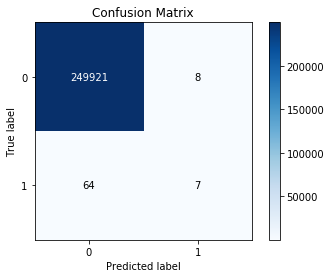

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

0.04211985264616843
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.43      0.04      0.08        71

    accuracy                           1.00    250000
   macro avg       0.71      0.52      0.54    250000
weighted avg       1.00      1.00      1.00    250000



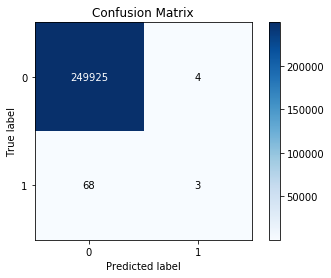

0.08240665766981556
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       1.00      0.06      0.11        71

    accuracy                           1.00    250000
   macro avg       1.00      0.53      0.55    250000
weighted avg       1.00      1.00      1.00    250000



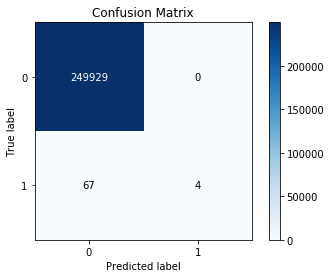

In [83]:
#Remove scaled
#add second loop for 2 sampler dfs / or concat?
#Get all model outputs at once
for samp in ['SMOTE','ROS']:
    for model in final_models.values():
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)

        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring = 'f1')

        print('Model: 'model)
        print('Training F1 Score: 'scores.mean())
        print('Test F1 Score: 'f1_score(y_pred, y_test))
        print(classification_report(y_test, y_pred))
        skplt.metrics.plot_confusion_matrix(y_test, y_pred)
        plt.show();

In [81]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [109]:
RandomOverSampler().get_params()

{'random_state': None, 'sampling_strategy': 'auto'}

In [241]:
#Random Over Sampler
ros = RandomOverSampler(sampling_strategy=0.001, random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_scaled, y_train_scaled)

In [223]:
y_ros

0         0
1         0
2         0
3         0
4         0
         ..
824804    1
824805    1
824806    1
824807    1
824808    1
Name: Clicked, Length: 824809, dtype: int32

In [230]:
y_ros.sum()

74982

In [224]:
X_ros[750550:]

,InteractionTime,BannerArea,Hour,DayWeek,Month,Weekend,ClickCount,ViewCount,TimeCount,Website_Amazon,...,Brand_gymboree,colour_Gold,colour_Pink,colour_Red,colour_White,colour_Yellow,colour_other,"TimeBin_(6.0, 12.0]","TimeBin_(12.0, 18.0]","TimeBin_(18.0, 24.0]"
750550,0.883080,75000.000000,15,0,1,0,0,5,11.108814,0,...,0,0,0,0,0,1,0,0,1,0
750551,0.514487,106642.742056,13,6,9,1,0,2,3.088775,0,...,0,0,0,0,0,1,0,0,1,0
750552,2.584656,75000.000000,7,6,1,1,0,18,19.351178,0,...,0,1,0,0,0,0,0,1,0,0
750553,0.734178,106642.742056,1,1,12,0,0,0,0.734178,0,...,0,0,0,0,0,0,0,0,0,0
750554,1.021258,106642.742056,16,4,11,0,0,3,9.405292,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824804,0.333950,106642.742056,19,1,1,0,0,0,0.333950,0,...,0,0,1,0,0,0,0,0,0,1
824805,0.883080,75000.000000,15,0,1,0,0,5,11.108814,0,...,0,0,0,0,0,1,0,0,1,0
824806,0.038244,180000.000000,18,3,1,0,0,9,6.390075,0,...,1,0,0,0,0,0,1,0,1,0
824807,0.421532,75000.000000,1,1,8,0,1,4,5.888823,0,...,0,0,1,0,0,0,0,0,0,0


In [111]:
SMOTE().get_params()

{'k_neighbors': 5,
 'n_jobs': None,
 'random_state': None,
 'sampling_strategy': 'auto'}

In [271]:
#SMOTE
smote = SMOTE(sampling_strategy=0.001, random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train_scaled)

In [159]:
sum(y_test)

71

In [204]:
sum(y_smote)

7500

In [74]:
#OLD
LR_proba = LRmodel.predict_proba(X_test_scaled)[:, 1]

print(roc_auc_score(y_test, LR_proba))

0.7082041158844041


In [75]:
LRmodel.predict_proba(X_test_scaled)

array([[9.99611442e-01, 3.88557947e-04],
       [9.99773310e-01, 2.26690026e-04],
       [9.99451939e-01, 5.48060988e-04],
       ...,
       [9.99799171e-01, 2.00828672e-04],
       [9.99908463e-01, 9.15371738e-05],
       [9.99698093e-01, 3.01906841e-04]])

In [81]:
#!!!!!!!!!!
#BEST MODEL
#Reducing predicted probability to 0.01 works v well on the test set
#This makes intuitive sense since we can never have high confidence in such an imbalanced dataset

print(classification_report(y_test, (LR_proba  >= 0.01).astype(int)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.46      0.15      0.23        71

   micro avg       1.00      1.00      1.00    250000
   macro avg       0.73      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



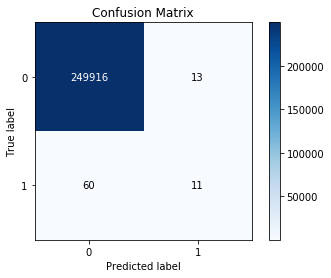

In [82]:
skplt.metrics.plot_confusion_matrix(y_test, (LR_proba  >= 0.01).astype(int));

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 DecisionTreeClassifier(max_depth=5, max_features=10,
                                        random_state=42))])
Training F1 Score: 0.1687546480115964
Test F1 Score: 0.15730337078651685
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.39      0.10      0.16        71

    accuracy                           1.00    250000
   macro avg       0.69      0.55      0.58    250000
weighted avg       1.00      1.00      1.00    250000



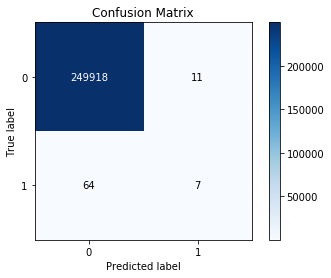

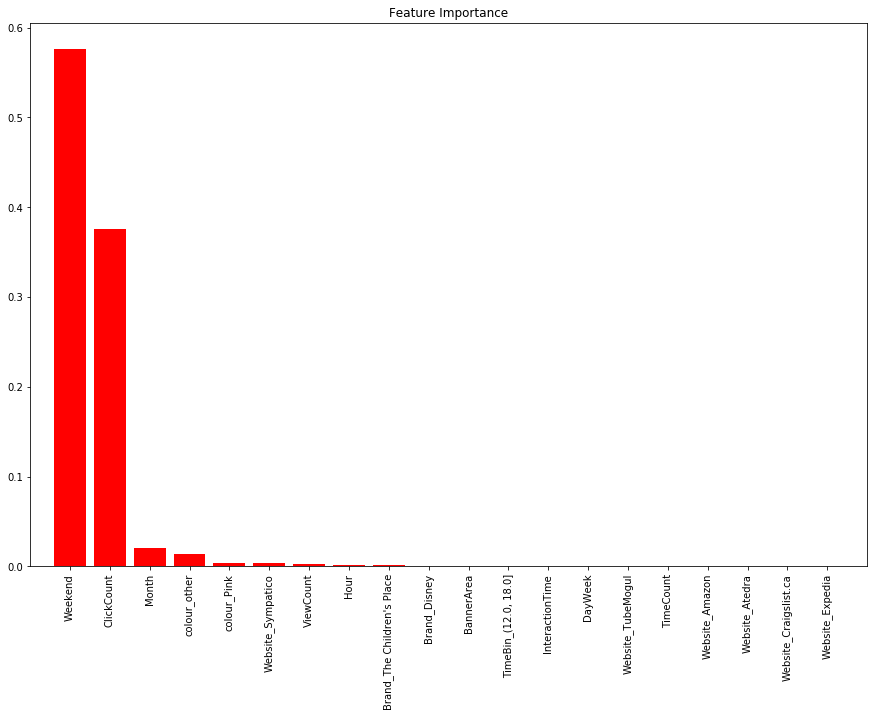

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 LogisticRegression(C=0.01, max_iter=50, penalty='none',
                                    random_state=42))])
Training F1 Score: 0.19495732278371708
Test F1 Score: 0.23157894736842108
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.46      0.15      0.23        71

    accuracy                           1.00    250000
   macro avg       0.73      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



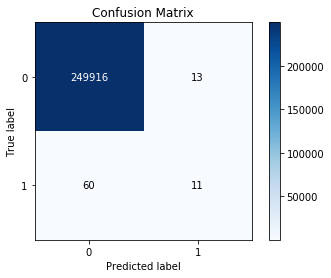

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 DecisionTreeClassifier(max_depth=5, max_features=10,
                                        random_state=42))])
Training F1 Score: 0.2049206349206349
Test F1 Score: 0.21505376344086022
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.45      0.14      0.22        71

    accuracy                           1.00    250000
   macro avg       0.73      0.57      0.61    250000
weighted avg       1.00      1.00      1.00    250000



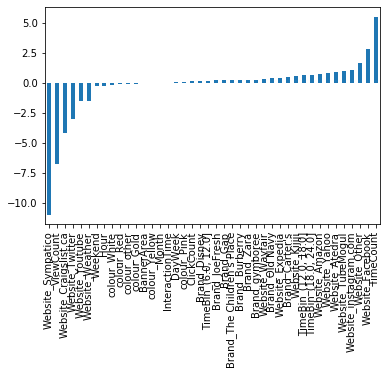

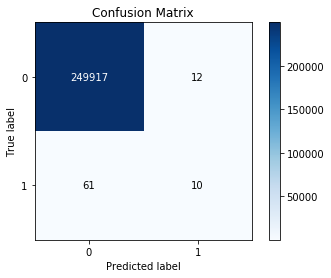

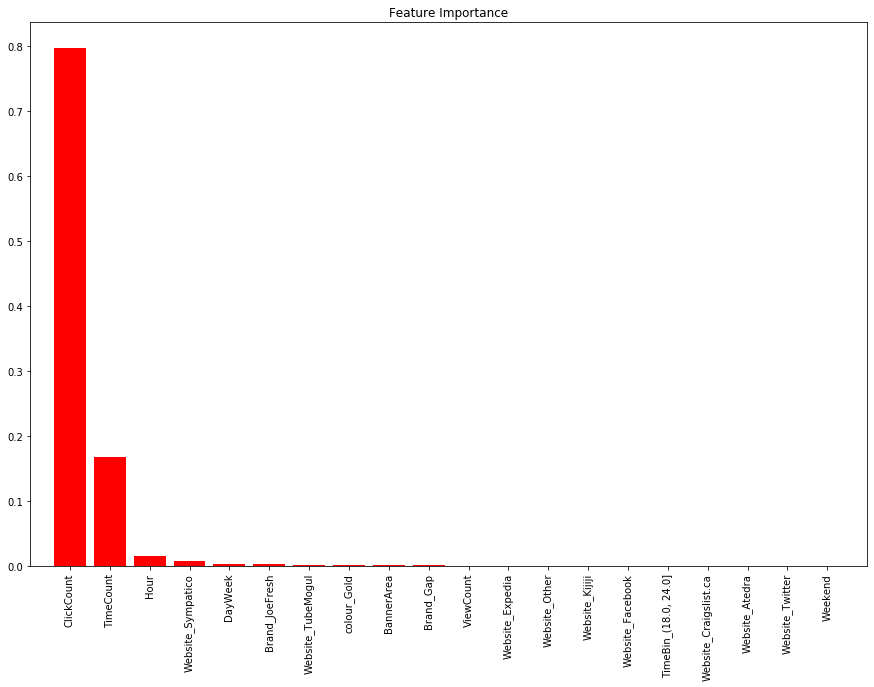

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 LogisticRegression(C=0.01, max_iter=50, penalty='none',
                                    random_state=42))])
Training F1 Score: 0.19495732278371708
Test F1 Score: 0.23404255319148937
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.48      0.15      0.23        71

    accuracy                           1.00    250000
   macro avg       0.74      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



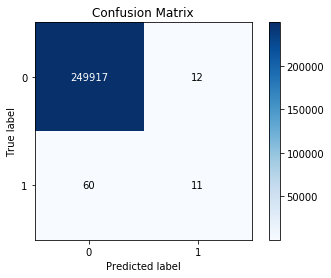

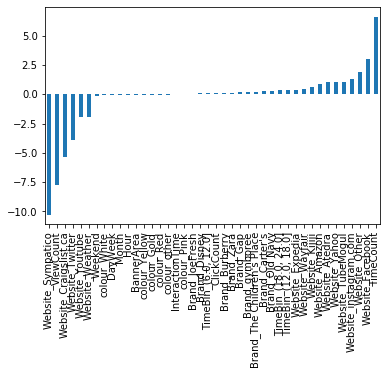

In [123]:
#add second loop for 2 sampler dfs / or concat?
#Get all model outputs at once
for samp in ['SMOTE','ROS']:
    for pipeline in END_models[samp]:
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'f1')

        print(f'Model: {pipeline}')
        print(f'Training F1 Score: {scores.mean()}')
        print(f'Test F1 Score: {f1_score(y_pred, y_test)}')
        print(classification_report(y_test, y_pred))
        skplt.metrics.plot_confusion_matrix(y_test, y_pred)
        try:
            skplt.estimators.plot_feature_importances(pipeline['mod'], feature_names=X.columns, \
                                                      figsize=(15, 10), x_tick_rotation=90)
            plt.show();
        except:
            plt.show()
            pd.Series(pipeline['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar')